<a href="https://colab.research.google.com/github/nataliamarinn/dm_grupo4/blob/main/Pruebas_nuestras_caras_V4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Grupo 4: Nuestras caras - fase inicial***


En este código se prueba la lectura de las imágenes, la asignación de etiquetas, el recorte facial, la transformación a escala de grises, el resize a 30x30, la aplicación de CP, la reconstrucción de las imágenes con las CP seleccionadas.

## **Carga de datos y librerías**

Cuando se usa Colab, el entorno ya viene con muchas librerías preinstaadas. Una de ellas es protobuf, pero suele estar en una versión más nueva, que no es compatible con agunas versiones de mediapipe.

In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp

In [2]:
import os # permite trabajar con rutas y carpetas - en este caso para recorrer las imágenes de las carpetas
import cv2 # sirve para leer imágenes y mostrarlas
import numpy as np # para convertir las imágenes en arrays
import mediapipe as mp # biblioteca de Google para detección de rostro
import matplotlib.pyplot as plt # herramienta de visualización
from sklearn.preprocessing import LabelEncoder # para transformar etiquetas
import pandas as pd # para crear y manejar dataframes
from sklearn.model_selection import StratifiedShuffleSplit # sirve para dividir en testing y training, asegurando estratificación
from sklearn.decomposition import PCA #para poder aplicar componentes principales


In [3]:
# Ruta donde están las carpetas de personas
input_folder = "C:/Users/Guadalupe/Documents/GitHub/MCD/data_mining_avanzado/eigenfaces/data/crudas/"


## **Detección de rostros**


Vamos autilizar **FaceMesh**, un modelo de MediaPipe de Google que permite la detección y el mapeo detallado de rostros en imágenes o videos. Facemesh devuelve puntos claves (*landmarks*), que tiene un valor x,y (posición relativa en la imagen) y z la profundidad estimada.
Links útiles:
- https://ai.google.dev/edge/mediapipe/solutions/vision/face_landmarker/python?hl=es-419
- https://omes-va.com/malla-facial-mediapipe-python/
- https://github.com/google-ai-edge/mediapipe/blob/master/mediapipe/python/solutions/face_mesh_connections.py

*Nota: al estar trabajando en Colab, algunas librerías presentan problemas de falla por GPU/CUDA. Nos pasó con dlib que crasheaba la RAM y con face_recognition no dejó instalarlo* ☹

In [4]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True, max_num_faces=1)

face_indices = [33, 133, 362, 263, 1, 2, 98, 327, 152, 10, 176, 397, 365, 379, 378, 400, 377]

In [5]:
# Almacenar imágenes procesadas y etiquetas
imagenes_procesadas = []
etiquetas = []

In [6]:
# Recorrer carpetas/personas
for persona in os.listdir(input_folder): # este for recorre cada carpeta del directorio
    carpeta = os.path.join(input_folder, persona) # cada carpeta a su vez tiene un nombre de persona, que sera luego etiqueta
    if os.path.isdir(carpeta):
        for archivo in os.listdir(carpeta):
            if archivo.lower().endswith((".jpg", ".jpeg", ".png")): #chequea que sea una imagen y también que la extensión sea en minúscula porque había algunas extensiones en mayúsculas
                path_img = os.path.join(carpeta, archivo)
                image = cv2.imread(path_img) #lee la imagen
                if image is None:
                    continue

                h, w, _ = image.shape
                img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # OpenCV lee en formato BGR pero la librería MediaPipe requiere RGB, por lo que hay que transformar
                results = face_mesh.process(img_rgb)  #detección de las caras

                if results.multi_face_landmarks: # si detecta una cara
                    landmarks = results.multi_face_landmarks[0].landmark #extrae los puntos de la cara
                    puntos = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in face_indices] # se multiplican por w y h para obtener las coordenadas en píxeles.

                    #y ahora definimos donde va a ser el "recorte"

                    x_min = max(min(p[0] for p in puntos), 0)
                    x_max = min(max(p[0] for p in puntos), w)
                    y_min = max(min(p[1] for p in puntos), 0)
                    y_max = min(max(p[1] for p in puntos), h)

                    rostro = image[y_min:y_max, x_min:x_max]  #recortamos

                    if rostro.size == 0: #chequeamos que no nos quedó nulo
                        continue

                    # pasamos a escala de grises para simplificar la información que trae los colores
                    rostro_gray = cv2.cvtColor(rostro, cv2.COLOR_BGR2GRAY)

                    # Redimensionar a 60x60
                    rostro_redimensionado = cv2.resize(rostro_gray, (60, 60))

                    # Guardar imagen procesada y su etiqueta
                    imagenes_procesadas.append(rostro_redimensionado)
                    etiquetas.append(persona)

print(f"Nro. de imágenes procesadas: {len(imagenes_procesadas)}")

Nro. de imágenes procesadas: 426


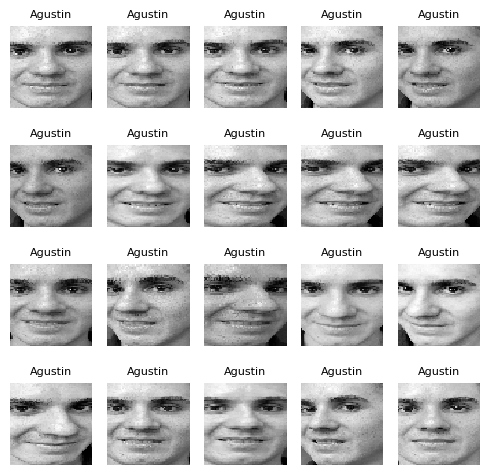

In [7]:
#imprimimos algunas imágenes para ver como quedó
fig, axs = plt.subplots(4,5, figsize=(5, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(imagenes_procesadas[i+8], cmap='gray', interpolation='nearest') #el i+8 o puse para no ver todas las fotos de José al principio
    ax.set_title(etiquetas[i+8], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [25]:
# Guardamos las imágenes con las etiquetas
output_folder = "C:/Users/Guadalupe/Documents/GitHub/MCD/data_mining_avanzado/eigenfaces/data/content/caras_60x60"
os.makedirs(output_folder, exist_ok=True)

filenames = []

for i, img in enumerate(imagenes_procesadas):
    filename = f"cara_{i}.jpg"
    path = os.path.join(output_folder, filename)
    cv2.imwrite(path, img)
    filenames.append(filename)

df = pd.DataFrame({
    "filename": filenames,
    "label": etiquetas
})

csv_path = "C:/Users/Guadalupe/Documents/GitHub/MCD/data_mining_avanzado/eigenfaces/data/content/caras_60x60_etiquetas.csv"
df.to_csv(csv_path, index=False)

print(f"CSV guardado en: {csv_path}")

CSV guardado en: C:/Users/Guadalupe/Documents/GitHub/MCD/data_mining_avanzado/eigenfaces/data/content/caras_60x60_etiquetas.csv


In [10]:
df.head()

,filename,label
0,cara_0.jpg,Agustin
1,cara_1.jpg,Agustin
2,cara_2.jpg,Agustin
3,cara_3.jpg,Agustin
4,cara_4.jpg,Agustin


# ***ACP***

In [26]:
# Paths
folder = "C:/Users/Guadalupe/Documents/GitHub/MCD/data_mining_avanzado/eigenfaces/data/content/caras_60x60"
csv_labels = "C:/Users/Guadalupe/Documents/GitHub/MCD/data_mining_avanzado/eigenfaces/data/content/caras_60x60_etiquetas.csv"


In [27]:
df = pd.read_csv(csv_labels) #cargamos un dataframe de dos columnas, con los nombres de los archivos y las etiquetas (nombre de la persona)

X = []
y = []

for _, row in df.iterrows(): #cargamos cada imagen
    filename = row['filename']
    label = row['label']
    path = os.path.join(folder, filename)

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_flat = img.flatten() #aplanarla
        X.append(img_flat)
        y.append(label)


X = np.array(X) #cada imagen a un array
y = np.array(y) #cada etiqueta a un array

print(f"Nro imágenes cargadas: {X.shape}, Labels: {len(np.unique(y))}")
y = np.array(y)

Nro imágenes cargadas: (426, 3600), Labels: 13


Vamos a dividir en traing y testing pero lo vamos a hacer estratificado para asegurarnos que considere al menos una foto de cada uno.

In [28]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f" Training set: {X_train.shape[0]} caras")
print(f"Testing set:  {X_test.shape[0]} caras")

 Training set: 340 caras
Testing set:  86 caras


In [29]:
from sklearn.preprocessing import StandardScaler
#es necesario estandarizar

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:

# Queremos calcular TODAS las componentes posibles
pca = PCA()  # sin limitar n_components
X_train_pca_full = pca.fit_transform(X_train_scaled)
X_test_pca_full = pca.transform(X_test_scaled)

print(f"Nro. de componentes principales: {X_train_pca_full.shape[1]}")


Nro. de componentes principales: 340


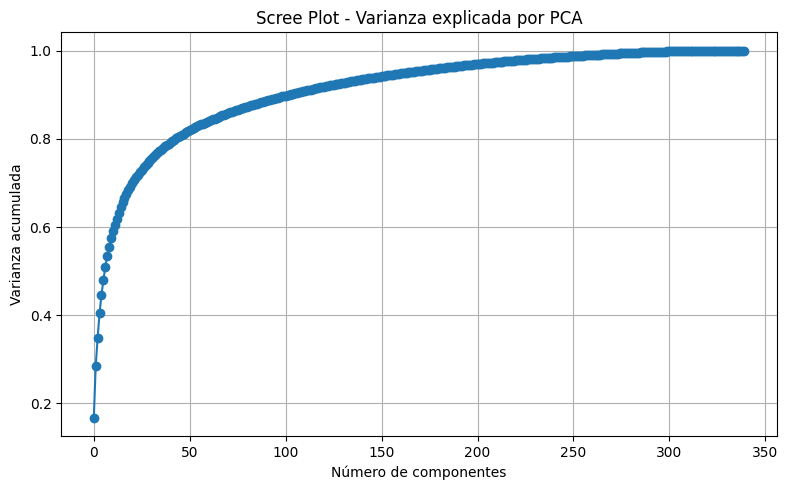

In [31]:

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.title("Scree Plot - Varianza explicada por PCA")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
var_cumulada = np.cumsum(pca.explained_variance_ratio_)
n_85 = np.argmax(var_cumulada >= 0.85) + 1
print(f" Se necesitan {n_85} componentes para explicar el 85% de la varianza")


 Se necesitan 67 componentes para explicar el 85% de la varianza


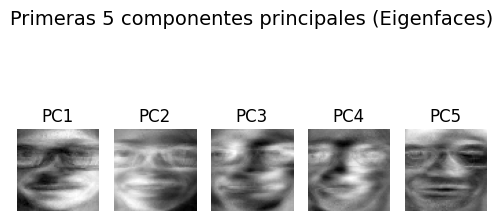

In [33]:
k = 5  # Número de componentes principales a visualizar
fig, axs = plt.subplots(1, k, figsize=(5, 3))
fig.suptitle(f"Primeras {k} componentes principales (Eigenfaces)", fontsize=14)
for i in range(k):
    eigenface = pca.components_[i].reshape(60, 60)
    axs[i].imshow(eigenface, cmap='gray')
    axs[i].set_title(f"PC{i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Vamos a reconstruir las imágenes con las CP seleccionadas y luego veremos como quedan


In [34]:
pca_51 = PCA(n_components=51)
X_train_pca = pca_51.fit_transform(X_train_scaled)
X_test_pca = pca_51.transform(X_test_scaled)

In [35]:
X_train_reconstructed = pca_51.inverse_transform(X_train_pca)
X_test_reconstructed = pca_51.inverse_transform(X_test_pca)


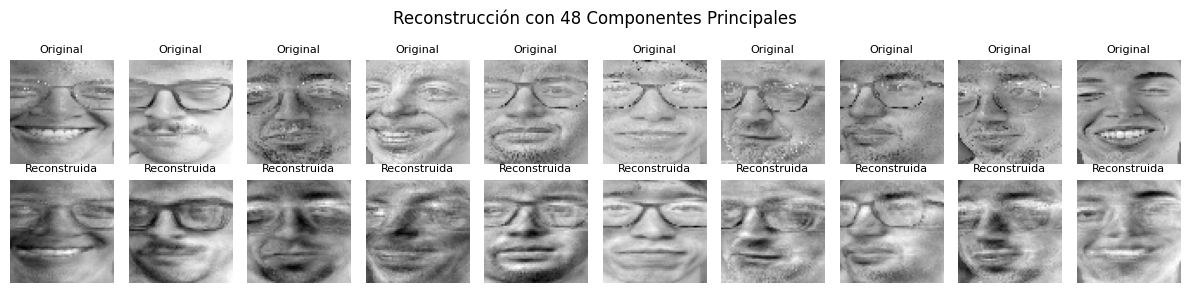

In [36]:
n = 10  # cantidad de imágenes a mostrar
fig, axs = plt.subplots(2, n, figsize=(12, 3))

for i in range(n):
    # Original
    axs[0, i].imshow(X_train_scaled[i].reshape(60, 60), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title("Original", fontsize=8)

    # Reconstruida
    axs[1, i].imshow(X_train_reconstructed[i].reshape(60, 60), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title("Reconstruida", fontsize=8)

plt.suptitle("Reconstrucción con 48 Componentes Principales", fontsize=12)
plt.tight_layout()
plt.show()

## **Y si cambiamos algunos parámetros?**

**Versión 1.1** - En esta versión probamos otros landmarks, en particular el de face oval de Google

In [ ]:
# Ruta donde están las carpetas de personas
input_folder = "/content/dm_grupo4/Eigenfaces"
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True, max_num_faces=1)

face_indices = [
    10, 338, 297, 332, 284, 251, 389, 356,
    454, 323, 361, 288, 397, 365, 379, 378,
    400, 377, 152, 148, 176, 149, 150, 136,
    172, 58, 132, 93, 234, 127, 162, 21,
    54, 103, 67, 109
]